Geodata-Harvester Notebook - Step by Step
-----------------------------------------------

-------------------------

The Geodata Harvester enables researchers with reusable workflows for automatic data extraction from a range of data sources including spatial-temporal processing into useable formats. User provided data is auto-completed with a suitable set of spatial- and temporal-aligned covariates as a ready-made dataset for machine learning and agriculture models. In addition, all requested data layer maps are automatically extracted and aligned for a specific region and time period. 

The main workflow of the Harvester is as follows: 

1) Options and user settings (e.g., data layer selections, spatial coverage, temporal constraints, i/o directory names) are defined by the user in the notebook settings menu or can be loaded with a settings yaml file  All settings are also saved in a yaml file for reusability.
2) The notebook imports settings and all Python modules that include functionality to download and extract data for each data source. After settings are read in, checked, and processed into valid data retrieval (API) queries, all selected data layers are sequentially downloaded and then processed into a clean dataframe table and co-registered raster maps. The entire workflow can be run either completely automatically or individually by selecting only certain process parts in the Notebook.

Additional data sources can be best added by writing the API handlers and extraction functionalities as separate Python module, which are then imported by the Notebook. Currently the following data sources are supported by the following modules:

- 'getdata_slga.py': Soil Data from Soil and Landscape Grid of Australia (SLGA)
- 'getdata_landscape': Landscape data from Soil and Landscape Grid of Australia (SLGA)
- 'getdata_silo.py': Climate Data from SILO
- 'getdata_dem.py: 'National Digital Elevation Model (DEM) 1 Second plus Slope and Apect calculation
- 'getdata_dea_nci.py: 'Digital Earth Australia's (DEA) Geoscience Earth Observations via NCI server
- 'getdata_dea.py: 'Digital Earth Australia's (DEA) Geoscience Earth Observations via Open Web Service server provided by DEA
- 'getdata_radiometric.py': Geoscience Australia National Geophysical Compilation Sub-collection Radiometrics
- 'eeharvest': Google Earth Engine API integration handler.

NOTE THAT USAGE OF GEE REQUIRES A GOOGLE EARTH ENGINE ACCOUNT AND AUTHENTICATION. Please see [GEE Setup](https://sydney-informatics-hub.github.io/AgReFed-Workshop/pydocs/setup-gee) to set up your GEE account. 

### Import libraries

In [1]:
# Load general python libraries
import os
import time
from datetime import datetime
from os.path import exists
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from types import SimpleNamespace

# Load geodata_harvester modules/functions/packages
# See each python file for detailed options
import geodata_harvester as gh

import eeharvest
from geodata_harvester import utils, settingshandler, temporal
from geodata_harvester.arc2meter import calc_arc2meter
from geodata_harvester.utils import init_logtable, update_logtable
from geodata_harvester.widgets import harvesterwidgets as hw

## DIY settings configuration file

Let's start with loading all user settings and options as specified in the settings file. For this example we provide a template file `settings/settings_simple.yaml`. You can use the default settings in this file or create your own settings file with widgets (see notebook `example_harvest_widgets.ipynb`).
Or you may changed the file directly, or point to a new file.
Or override any of the defaults throughout this notebook.
This is the core piece of the Geodata Harvester that makes the data collection reproducible. 

In [2]:
# Path to file:
path_settings = 'settings'
# Filename
fname_settings = 'settings_simple.yaml'
infname = os.path.join(path_settings,fname_settings)

Let's have a look at the settings file:


In [3]:
# print settings as json
settingshandler.display_settings(infname)

{
    "colname_lat": "Lat",
    "colname_lng": "Long",
    "date_max": "2022-11-30",
    "date_min": "2022-10-01",
    "infile": "data/example-site_llara.csv",
    "outpath": "results_technical/",
    "target_bbox": null,
    "target_res": 6.0,
    "target_sources": {
        "DEA": [
            "landsat_barest_earth"
        ],
        "DEM": [
            "DEM"
        ],
        "GEE": {
            "download": {
                "bands": "NDVI"
            },
            "preprocess": {
                "bound": null,
                "buffer": null,
                "collection": "LANDSAT/LC09/C02/T1_L2",
                "mask_clouds": true,
                "reduce": "median",
                "spectral": "NDVI"
            }
        },
        "Landscape": [
            "Slope",
            "Aspect"
        ],
        "Radiometric": [
            "radmap2019_grid_dose_terr_awags_rad_2019"
        ],
        "SILO": {
            "max_temp": "mean",
            "min_temp": "mean",
   

You may notice that there is no bounding box specified. To validate the settings and to automatically calculate the bounding box we need to run the following code snippet:

In [4]:
# store settings as namespace (easier to interact with)
settings = settingshandler.main(infname)

# Print settings
hw.print_settings(settings)

Settings loaded:
----------------
settings.infile : data/example-site_llara.csv
settings.outpath : results_technical/
settings.colname_lat : Lat
settings.colname_lng : Long
settings.target_bbox : (149.769345, -30.335861, 149.949173, -30.206271)
settings.target_res : 6.0
settings.date_min : 2022-10-01
settings.date_max : 2022-11-30
settings.time_intervals : 1
settings.target_sources:
   'DEA': ['landsat_barest_earth']
   'DEM': ['DEM']
   'Landscape': ['Slope', 'Aspect']
   'Radiometric': ['radmap2019_grid_dose_terr_awags_rad_2019']
   'SILO': {'min_temp': 'mean', 'max_temp': 'mean', 'monthly_rain': 'sum'}
   'SLGA': {'Bulk_Density': ['0-5cm']}
   'GEE': {'preprocess': {'collection': 'LANDSAT/LC09/C02/T1_L2', 'buffer': None, 'bound': None, 'mask_clouds': True, 'reduce': 'median', 'spectral': 'NDVI'}, 'download': {'bands': 'NDVI'}}


As you can see the bounding box is now calculated by using the extent of the locations in the input file plus a padding of 0.05 deg

In [5]:
print('Bounding box:', settings.target_bbox)

Bounding box: (149.769345, -30.335861, 149.949173, -30.206271)


## Setup dataset of interest

Here we are reading in the point locations for which we want to extract data. A custom bounding box for which to extract raster data can be set in the settings file. If no bounding box provided, rasters are extracted for the region given by the point location extent plus an additional padding of 0.05 deg in Lat/Long (see code below).

In [6]:
# Load in the dataset defining our location of interest as a geopandas dataframe
gdfpoints = gpd.read_file(settings.infile)

# Assing the data to well-named variables
lngs = gdfpoints[settings.colname_lng].astype(float)
lats = gdfpoints[settings.colname_lat].astype(float)
coords = np.vstack((lngs, lats)).T

# Check the data looks reasonable
gdfpoints

,Lat,Long,geometry
0,-30.264663,149.85268,None
1,-30.265302,149.884838,None
2,-30.265302,149.884838,None
3,-30.278542,149.838791,None
4,-30.275437,149.830843,None
...,...,...,...
77,-30.268262,149.87615,None
78,-30.257031,149.880983,None
79,-30.258505,149.891118,None
80,-30.261989,149.884329,None


Since the resolution is specified in arcsec, we can check what it is in meters:

In [7]:
# Estimate resolution in meters:
lat_center = (settings.target_bbox[1]+settings.target_bbox[3])/2
xres_meters, yres_meters = calc_arc2meter(settings.target_res, lat_center)
print(f'Info: {settings.target_res} arcsec resolution corresponds to {xres_meters:.1f}m x {yres_meters:.1f}m in x,y direction respectively (at Latitude: {lat_center:.2f}).')

Info: 6.0 arcsec resolution corresponds to 160.2m x 185.2m in x,y direction respectively (at Latitude: -30.27).


## Setup temporal range

Calculate time preiod to aggregate data. In this example the number of time interval is one.

In [8]:
date_diff = (datetime.strptime(settings.date_max, "%Y-%m-%d") 
    - datetime.strptime(settings.date_min, "%Y-%m-%d")).days
if settings.time_intervals is not None:
    period_days = date_diff // settings.time_intervals
    if period_days == 0:
        period_days = 1
else:
    period_days = None
print(f'Time period: {period_days} days')

Time period: 60 days


<a id='download_and_process'></a>

## Download and process data from API sources

From here we automatically download and process sequentially a range of data sources as specified in the settings file (see next subsections: SLGA, SILO, DEA, DEM). Note that you may retrieve info and parameter input options for any function easily by running a function/method with a preceeding '?', e.g:
```
?getdata_slga.get_slga_layers
?utils
```

In [9]:
# Initiate a dataframe for logging all data output names and layer titles.
# Note that the log table is later updated with update_logtable(), 
# which also instantly saves a copy of the table of the current status.
df_log = init_logtable()

### SLGA Download

Here we download all requested data layers from the Soil and Landscape Grid of Australia (SLGA) for the given bounding box. Note that for this example we select the top soil (0 - 5cm) only. Optionally other layers and depths including confidence intervals can be extracted as well; for more details and options see getdata_slga.py.

In [10]:
# We can set the input options for each function call, and additional parameters may be set
# too. Check the documentation of each function for full list of options.
depth_min, depth_max = gh.getdata_slga.identifier2depthbounds(list(settings.target_sources['SLGA'].values())[0])
slga_layernames = list(settings.target_sources['SLGA'].keys())

fnames_out_slga = gh.getdata_slga.get_slga_layers(
    slga_layernames, 
    settings.target_bbox, 
    settings.outpath, 
    depth_min = depth_min, 
    depth_max= depth_max, 
    get_ci = True)

⚑ SLGA_Bulk_Density_0-5cm.tif already exists, skipping download
⚑ SLGA_Bulk_Density_0-5cm_5percentile.tif already exists, skipping download
⚑ SLGA_Bulk_Density_0-5cm_95percentile.tif already exists, skipping download


In [11]:
# Add download info to log dataframe
df_log = update_logtable(
    df_log, 
    fnames_out_slga, 
    slga_layernames, 
    'SLGA', 
    settings, 
    layertitles = [], loginfos = 'downloaded')
df_log

,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,results_technical/SLGA_Bulk_Density_0-5cm.tif,downloaded


### SILO Download

Here we download climate data layers from SILO and extract raster for the given bounding box and year.
For more details see getdata_silo.py. Note that the SILO download takes a couple of minutes depending on the number of requested data layers and speed of internet connection.

In [12]:
# Each data-source must be handled differently (as the data is stored in different ways)
# Here we must get each layer, one by one, which is automatically handled by the function get_SILO_layers().
outpath = os.path.join(settings.outpath, "silo")
silo_layernames = list(settings.target_sources['SILO'].keys())
# run the download
fnames_out_silo = gh.getdata_silo.get_SILO_layers(
    silo_layernames,
    settings.date_min,
    settings.date_max,
    outpath,
    bbox=settings.target_bbox,
    format_out="tif"
)

⚑ min_temp for 2022 already exists, skipping download
⚑ max_temp for 2022 already exists, skipping download
⚑ monthly_rain for 2022 already exists, skipping download


In [13]:
# temporal aggregation since each SILO file has multiple bands (1 band per day or 1 band per month)
outfname_list = []
layername_list = []
aggfunction_list = []
for i, fname in enumerate(fnames_out_silo):
    xdr = temporal.combine_rasters_temporal(fname, channel_name="band", attribute_name="long_name")
    outfnames, agg_list = temporal.aggregate_temporal(
        xdr,
        period=period_days, 
        agg=[settings.target_sources['SILO'][silo_layernames[i]]], 
        outfile=f"{fname.split('.')[0]}", 
        buffer = None)
    outfname_list += outfnames
    layername_list += [silo_layernames[i]]*len(outfnames)
    aggfunction_list += agg_list

mean of 2022-09-30 saved in: results_technical/silo/silo_min_temp_2022-10-01-2022-11-30_mean_2022-09-30.tif
mean of 2022-09-30 saved in: results_technical/silo/silo_max_temp_2022-10-01-2022-11-30_mean_2022-09-30.tif
sum of 2022-10-15 saved in: results_technical/silo/silo_monthly_rain_2022-10-01-2022-11-30_sum_2022-10-15.tif


In [14]:
# Add to log table
layer_titles = ["SILO_" + layername for layername in silo_layernames]
# Add download info to log dataframe
df_log = update_logtable(
    df_log,
    #fnames_out_silo,
    filenames = outfname_list,
    layernames = layername_list,
    datasource = "SILO",
    settings = settings,
    layertitles=[os.path.basename(fname).split('.')[0] for fname in outfname_list],
    agfunctions = aggfunction_list,
    loginfos="downloaded",
)

In [15]:
df_log

,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,results_technical/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,min_temp,mean,SILO,silo_min_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_min_temp_2022-10-0...,downloaded
2,max_temp,mean,SILO,silo_max_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_max_temp_2022-10-0...,downloaded
3,monthly_rain,sum,SILO,silo_monthly_rain_2022-10-01-2022-11-30_sum_20...,results_technical/silo/silo_monthly_rain_2022-...,downloaded


### SILO Processing
This is an example for simple processing of the extracted SILO data. Here we are interested in generating a mean temperature raster given the already extracted min and max temperature rasters. Generalised, we may aggregrate any list of rasters.

In [17]:
file_list = df_log[df_log['layername'].isin(['min_temp','max_temp'])].filename_out.to_list()
file_list

['results_technical/silo/silo_min_temp_2022-10-01-2022-11-30_mean_2022-09-30.tif',
 'results_technical/silo/silo_max_temp_2022-10-01-2022-11-30_mean_2022-09-30.tif']

In [18]:
agg = ['mean']

# Set a custom output name-prefix
outfile = settings.outpath+'silo_temp_ag'

# And run the processing
outfname_agg = utils.aggregate_rasters(
    file_list=file_list,
    outfile=outfile, 
    data_dir=None,
    agg=agg)

# Add processed info to log dataframe
df_log = update_logtable(df_log, 
                         [outfname_agg[0]], 
                         ['mean_temp'], 
                         'SILO', 
                         settings, 
                         layertitles = ['mean_temp'], 
                         agfunctions = ['mean'], 
                         loginfos = 'processed')
df_log

Finding ['mean']  out of possible ['mean', 'median', 'sum', 'perc95', 'perc5']
mean of filelist saved in:  results_technical/silo_temp_ag_mean.tif


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,results_technical/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,min_temp,mean,SILO,silo_min_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_min_temp_2022-10-0...,downloaded
2,max_temp,mean,SILO,silo_max_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_max_temp_2022-10-0...,downloaded
3,monthly_rain,sum,SILO,silo_monthly_rain_2022-10-01-2022-11-30_sum_20...,results_technical/silo/silo_monthly_rain_2022-...,downloaded
4,mean_temp,mean,SILO,mean_temp,results_technical/silo_temp_ag_mean.tif,processed


### DEA Download

Here we download satellite data from Digital Earth Australia (DEA) within the given bounding box and for all available image capture dates that are available within the specified year(s). To simplify this example and to speed up download we retrive a static image here only (landsat_barest_earth). For more details see getdata_dea.py.

In [19]:
dea_layernames = settings.target_sources['DEA']
print(dea_layernames)

# These are multiple files, so we put them in a subdirectory to make subsequent processing easier.
outpath_dea = os.path.join(settings.outpath,'temp_dea')

outfnames = gh.getdata_dea.get_dea_layers_daterange(
    dea_layernames, 
    settings.date_min,
    settings.date_max,
    settings.target_bbox, 
    settings.target_res, 
    outpath_dea, 
    crs = 'EPSG:4326', 
    format_out = 'GeoTIFF')

['landsat_barest_earth']
⚑ landsat_barest_earth.tif already exists, skipping download


In [20]:
# if multple layers we need to get list of filenames and metadata for the logfile
layer_list = []
for fname in outfnames:
    for layername in dea_layernames:
        if layername in fname:
            layer_list.append(layername)
            break
layer_titles = [os.path.basename(path).rsplit('.')[0] for path in outfnames]
agg_list = ['None']*len(layer_titles)

In [21]:
# Add extracted data info to log table
df_log = update_logtable(
    df_log, 
    outfnames, 
    layer_titles, 
    'DEA', 
    settings, 
    layertitles = layer_titles, 
    loginfos = 'processed',force=True)
#print(df_log.layertitle)
df_log

,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,results_technical/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,min_temp,mean,SILO,silo_min_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_min_temp_2022-10-0...,downloaded
2,max_temp,mean,SILO,silo_max_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_max_temp_2022-10-0...,downloaded
3,monthly_rain,sum,SILO,silo_monthly_rain_2022-10-01-2022-11-30_sum_20...,results_technical/silo/silo_monthly_rain_2022-...,downloaded
4,mean_temp,mean,SILO,mean_temp,results_technical/silo_temp_ag_mean.tif,processed
5,landsat_barest_earth,None,DEA,landsat_barest_earth,results_technical/temp_dea/landsat_barest_eart...,processed


### DEM Download

Here we download and extract the National Digital Elevation Model (DEM), and also generate slope and aspect rasters from the extracted DEM. 
For more details see getdata_dem.py

In [23]:
outpath = os.path.join(settings.outpath, "temp_dem")
dem_layernames = settings.target_sources['DEM']
outfnames = gh.getdata_dem.get_dem_layers(dem_layernames, outpath, settings.target_bbox, settings.target_res)

# Add extracted data to log dataframe
df_log = update_logtable(
    df_log, 
    outfnames, 
    dem_layernames, 
    'DEM', 
    settings, 
    layertitles = dem_layernames,
    loginfos = 'downloaded')
df_log

⊙ Retrieving coverage from WCS server 0.3s                             
⚑ DEM_SRTM_1_Second_Hydro_Enforced_2023_06_15.tif already exists, skipping download
Error: results_technical/temp_dem/DEM_SRTM_1_Second_Hydro_Enforced_2023_06_15.tif exists in df_log! Dataframe not updated.
Check your inputs or overwrite with force=True


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,results_technical/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,min_temp,mean,SILO,silo_min_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_min_temp_2022-10-0...,downloaded
2,max_temp,mean,SILO,silo_max_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_max_temp_2022-10-0...,downloaded
3,monthly_rain,sum,SILO,silo_monthly_rain_2022-10-01-2022-11-30_sum_20...,results_technical/silo/silo_monthly_rain_2022-...,downloaded
4,mean_temp,mean,SILO,mean_temp,results_technical/silo_temp_ag_mean.tif,processed
5,landsat_barest_earth,None,DEA,landsat_barest_earth,results_technical/temp_dea/landsat_barest_eart...,processed
6,DEM,None,DEM,DEM,results_technical/temp_dem/DEM_SRTM_1_Second_H...,downloaded


### Landscape

Download landscape data from Soil and Landscape Grid of Australia (SLGA).

In [24]:
# Download landscape data
layernames = settings.target_sources['Landscape']
layertitles = ['Landscape_' + layername for layername in layernames]

outfnames = gh.getdata_landscape.get_landscape_layers(
    layernames, 
    settings.target_bbox, 
    settings.outpath, 
    resolution = settings.target_res)

# Add extracted data to log dataframe
df_log = update_logtable(
    df_log, outfnames, 
    layernames, 
    'Landscape', 
    settings, 
    layertitles = layertitles,
    loginfos = 'downloaded')
df_log


⚑ Landscape_Slope.tif already exists, skipping download
⚑ Landscape_Aspect.tif already exists, skipping download


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,results_technical/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,min_temp,mean,SILO,silo_min_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_min_temp_2022-10-0...,downloaded
2,max_temp,mean,SILO,silo_max_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_max_temp_2022-10-0...,downloaded
3,monthly_rain,sum,SILO,silo_monthly_rain_2022-10-01-2022-11-30_sum_20...,results_technical/silo/silo_monthly_rain_2022-...,downloaded
4,mean_temp,mean,SILO,mean_temp,results_technical/silo_temp_ag_mean.tif,processed
5,landsat_barest_earth,None,DEA,landsat_barest_earth,results_technical/temp_dea/landsat_barest_eart...,processed
6,DEM,None,DEM,DEM,results_technical/temp_dem/DEM_SRTM_1_Second_H...,downloaded
7,Slope,None,Landscape,Landscape_Slope,results_technical/Landscape_Slope.tif,downloaded
8,Aspect,None,Landscape,Landscape_Aspect,results_technical/Landscape_Aspect.tif,downloaded


### Radiometrics

Download maps of Geoscience Australia National Geophysical Compilation Sub-collection Radiometrics

In [25]:
# Download radiometrics
layernames = settings.target_sources['Radiometric']

outfnames = gh.getdata_radiometric.get_radiometric_layers(
    settings.outpath, 
    layernames, 
    bbox = settings.target_bbox, 
    resolution=settings.target_res)

 # Add extracted data to log dataframe
df_log = update_logtable(
    df_log, outfnames, 
    layernames, 
    'Radiometric', 
    settings, 
    layertitles = layernames,
    loginfos = 'downloaded')
df_log

⚑ radmap2019_grid_dose_terr_awags_rad_2019.tif already exists, skipping download


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,results_technical/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,min_temp,mean,SILO,silo_min_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_min_temp_2022-10-0...,downloaded
2,max_temp,mean,SILO,silo_max_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_max_temp_2022-10-0...,downloaded
3,monthly_rain,sum,SILO,silo_monthly_rain_2022-10-01-2022-11-30_sum_20...,results_technical/silo/silo_monthly_rain_2022-...,downloaded
4,mean_temp,mean,SILO,mean_temp,results_technical/silo_temp_ag_mean.tif,processed
5,landsat_barest_earth,None,DEA,landsat_barest_earth,results_technical/temp_dea/landsat_barest_eart...,processed
6,DEM,None,DEM,DEM,results_technical/temp_dem/DEM_SRTM_1_Second_H...,downloaded
7,Slope,None,Landscape,Landscape_Slope,results_technical/Landscape_Slope.tif,downloaded
8,Aspect,None,Landscape,Landscape_Aspect,results_technical/Landscape_Aspect.tif,downloaded
9,radmap2019_grid_dose_terr_awags_rad_2019,None,Radiometric,radmap2019_grid_dose_terr_awags_rad_2019,results_technical/radiometric_radmap2019_grid_...,downloaded


--------------------------

<a id='google_earth_engine'></a>

## Google Earth Engine

To connect to Google Earth Engine, you must already have access to the Google
Earth Engine API. You can request for access [by clicking
here](https://earthengine.google.com/signup/). Once you are authorised, connect
to the API using `initialise()`. A web browser may be invoked to complete the
process.

In [26]:
# Connect to the Google Earth Engine API
eeharvest.initialise(auth_mode = 'notebook')

⊙ Initialising Earth Engine... 5.7s                                    
✔ Done


### Collect and preprocess Earth Engine Data

Use `collect()` to define the data object and `preprocess()` to perform server-side
data processing which includes cloud and shadow masking, image reduction and
calculation of spectral indices.

In [27]:
gee = settings.target_sources["GEE"]

# Define the collection, area of interest and date range
img = eeharvest.collect(collection=gee['preprocess']['collection'],
              coords=settings.target_bbox,
              date_min=settings.date_min, 
              date_max = settings.date_max)

# Perform cloud masking, reduction, and calculate one or more spectral indices
img.preprocess(mask_clouds=gee["preprocess"]["mask_clouds"], 
               reduce=gee["preprocess"]["reduce"], 
               spectral=gee["preprocess"]["spectral"])

Running preprocess() -----
ℹ Number of image(s) found: 3
⊙ Applying scale, offset and cloud masks... 1.7s                       
⊙ Calculating spectral indices: NDVI... 3.9s                           
✔ Preprocessing complete


### Download

Download the data using `download()` and add to `df_log`:

In [28]:
# Downoad data
img.download(bands=gee["download"]["bands"],
             scale=100, #gee["download"]["scale"],
             outpath=settings.outpath,
             out_format='tif') #gee["download"]["format"])


# Add to log dataframe
outfnames = [settings.outpath + '/' + img.filenames]
layernames = [Path(img.filenames).resolve().stem]

df_log = update_logtable(
    df_log,
    outfnames,
    layernames,
    "GEE",
    settings,
    layertitles=[],
    agfunctions=img.reduce,
    loginfos="downloaded",
    )

# Preview to log file 
df_log 

Running download() -----
ℹ Band(s) selected: ['NDVI_median']
ℹ Setting download dir to results_technical/
⚑ ee_LANDSAT_22455f15.tif already exists, skipping download
✔ Google Earth Engine download(s) complete


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,results_technical/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,min_temp,mean,SILO,silo_min_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_min_temp_2022-10-0...,downloaded
2,max_temp,mean,SILO,silo_max_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_max_temp_2022-10-0...,downloaded
3,monthly_rain,sum,SILO,silo_monthly_rain_2022-10-01-2022-11-30_sum_20...,results_technical/silo/silo_monthly_rain_2022-...,downloaded
4,mean_temp,mean,SILO,mean_temp,results_technical/silo_temp_ag_mean.tif,processed
5,landsat_barest_earth,None,DEA,landsat_barest_earth,results_technical/temp_dea/landsat_barest_eart...,processed
6,DEM,None,DEM,DEM,results_technical/temp_dem/DEM_SRTM_1_Second_H...,downloaded
7,Slope,None,Landscape,Landscape_Slope,results_technical/Landscape_Slope.tif,downloaded
8,Aspect,None,Landscape,Landscape_Aspect,results_technical/Landscape_Aspect.tif,downloaded
9,radmap2019_grid_dose_terr_awags_rad_2019,None,Radiometric,radmap2019_grid_dose_terr_awags_rad_2019,results_technical/radiometric_radmap2019_grid_...,downloaded


## Save the final log or start from here to re-load it in.
We have now completed the data download section. You may add additional downlods and processing steps to your log file.

In [29]:
# Save out (or load in) the log file.
logfile = settings.outpath+'log.csv'
if exists(logfile):
    print(logfile, "exists! Do you want to read it in?\n")
    user_input = input("(y)es / (n)o / (a)bort ? Ansering 'no' will overwrite the current file.\n")
    if user_input=='y':
        df_log = pd.read_csv(settings.outpath+'log.csv')
    elif user_input =='n': 
        df_log.to_csv(settings.outpath+'log.csv',index=False)
        print(logfile, "saved!")
    else:
        print("Cancelling read/write for log file.\nFigure out what you want to do and please try again.")
else:
    print("No log file found. Saving to", settings.outpath+'log.csv')
    df_log.to_csv(settings.outpath+'log.csv',index=False)

df_log

results_technical/log.csv exists! Do you want to read it in?

(y)es / (n)o / (a)bort ? Ansering 'no' will overwrite the current file.
n
results_technical/log.csv saved!


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,results_technical/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,min_temp,mean,SILO,silo_min_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_min_temp_2022-10-0...,downloaded
2,max_temp,mean,SILO,silo_max_temp_2022-10-01-2022-11-30_mean_2022-...,results_technical/silo/silo_max_temp_2022-10-0...,downloaded
3,monthly_rain,sum,SILO,silo_monthly_rain_2022-10-01-2022-11-30_sum_20...,results_technical/silo/silo_monthly_rain_2022-...,downloaded
4,mean_temp,mean,SILO,mean_temp,results_technical/silo_temp_ag_mean.tif,processed
5,landsat_barest_earth,None,DEA,landsat_barest_earth,results_technical/temp_dea/landsat_barest_eart...,processed
6,DEM,None,DEM,DEM,results_technical/temp_dem/DEM_SRTM_1_Second_H...,downloaded
7,Slope,None,Landscape,Landscape_Slope,results_technical/Landscape_Slope.tif,downloaded
8,Aspect,None,Landscape,Landscape_Aspect,results_technical/Landscape_Aspect.tif,downloaded
9,radmap2019_grid_dose_terr_awags_rad_2019,None,Radiometric,radmap2019_grid_dose_terr_awags_rad_2019,results_technical/radiometric_radmap2019_grid_...,downloaded


--------------------------

<a id='point_extraction'></a>

## Points extraction from downloaded/processed data

By default point values of all processed layers in df_log are extracted given by the input locations. However, you can select also only certain layers (see in code). 

In [30]:
# Select all processed data
df_sel = df_log.copy()

# or select only the rasters of interest, for example:
"""
df_sel = df_log[df_log['layername'].isin(['DEM','Slope',
'landsat8_nbart_16day_channel0', 
'Organic_Carbon','Depth_of_Soil',
'mean_temp','monthly_rain'])]
"""

rasters= df_sel['filename_out'].values.tolist()
titles = df_sel['layertitle'].values.tolist()
    
# Extract datatable from rasters given input coordinates
gdf = utils.extract_values_from_rasters(coords, rasters)
#gdf = utils.raster_query(lngs,lats,rasters,titles)

⊙ Extracting values from raster files... (!) 0.4s 


### Inspect result dataframe

In [31]:
# Inspect either entire generated dataframe with 
# gdf
# or only the first rows
gdf.head()

,Longitude,Latitude,SLGA_Bulk_Density_0-5cm_1,silo_min_temp_2022-10-01-2022-11-30_mean_2022-09-30_1,silo_max_temp_2022-10-01-2022-11-30_mean_2022-09-30_1,silo_monthly_rain_2022-10-01-2022-11-30_sum_2022-10-15_1,silo_temp_ag_mean_1,landsat_barest_earth_red,landsat_barest_earth_green,landsat_barest_earth_blue,landsat_barest_earth_nir,landsat_barest_earth_swir1,landsat_barest_earth_swir2,DEM_SRTM_1_Second_Hydro_Enforced_2023_06_15_1,Landscape_Slope_1,Landscape_Aspect_1,radiometric_radmap2019_grid_dose_terr_awags_rad_2019_radmap2019_grid_dose_terr_awags_rad_2019,ee_LANDSAT_22455f15_NDVI_median,geometry
0,149.852680,-30.264663,1.368779,11.840984,25.539341,269.699951,18.690163,1059.0,809.0,541.0,1719.0,2162.0,1815.0,244.658585,1.046624,209.138062,33.151680,0.302978,POINT (149.85268 -30.26466)
1,149.884838,-30.265302,1.362662,11.695084,25.439339,263.199951,18.567211,1082.0,819.0,540.0,1702.0,2083.0,1800.0,264.428772,1.001000,279.542847,35.969486,0.128607,POINT (149.88484 -30.26530)
2,149.884838,-30.265302,1.362662,11.695084,25.439339,263.199951,18.567211,1082.0,819.0,540.0,1702.0,2083.0,1800.0,264.428772,1.001000,279.542847,35.969486,0.128607,POINT (149.88484 -30.26530)
3,149.838791,-30.278542,1.360451,11.926229,25.703279,258.599854,18.814754,1092.0,859.0,601.0,1801.0,2369.0,1961.0,233.005081,0.841430,242.743683,29.618393,0.255374,POINT (149.83879 -30.27854)
4,149.830843,-30.275437,1.334362,11.926229,25.703279,258.599854,18.814754,1160.0,907.0,626.0,1901.0,2555.0,2106.0,230.575439,1.062537,242.921112,25.061012,0.463382,POINT (149.83084 -30.27544)


In [32]:
# Get some general info about result table:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 19 columns):
 #   Column                                                                                         Non-Null Count  Dtype   
---  ------                                                                                         --------------  -----   
 0   Longitude                                                                                      82 non-null     float64 
 1   Latitude                                                                                       82 non-null     float64 
 2   SLGA_Bulk_Density_0-5cm_1                                                                      82 non-null     float64 
 3   silo_min_temp_2022-10-01-2022-11-30_mean_2022-09-30_1                                          82 non-null     float64 
 4   silo_max_temp_2022-10-01-2022-11-30_mean_2022-09-30_1                                          82 non-null     float64 
 5   silo_mont

### Save the results table

Finally, the result dataframe table is saved as a csv file, which can be used now to do some analysis or ML.
In addition the results are also saved as a geo-spatial referenced geopackage (.gpkg), which can be used again as input for further analysis or to inspect and overlay data on other layers and basemaps. The geopackage is a standard georeferenced file format and can be opened with any geo-spatial package or interactive software (e.g., QGIS, Esri ArcGIS). 

In [33]:
# Save the results table to a csv 
gdf.to_csv(os.path.join(settings.outpath, "results.csv"), index = True, mode='w')

# Save also as geopackage
gdf.to_file(os.path.join(settings.outpath, "results.gpkg"), driver="GPKG")
# Note: The deprecated warning below is a bug in geopandas and will be fixed in their bext version.

--------------------------

<a id='overview_plot'></a>

## Overview plot of all processed rasters 

This provides a quick overview to inspect all processed data layers with an overlay of the requested location points.
  

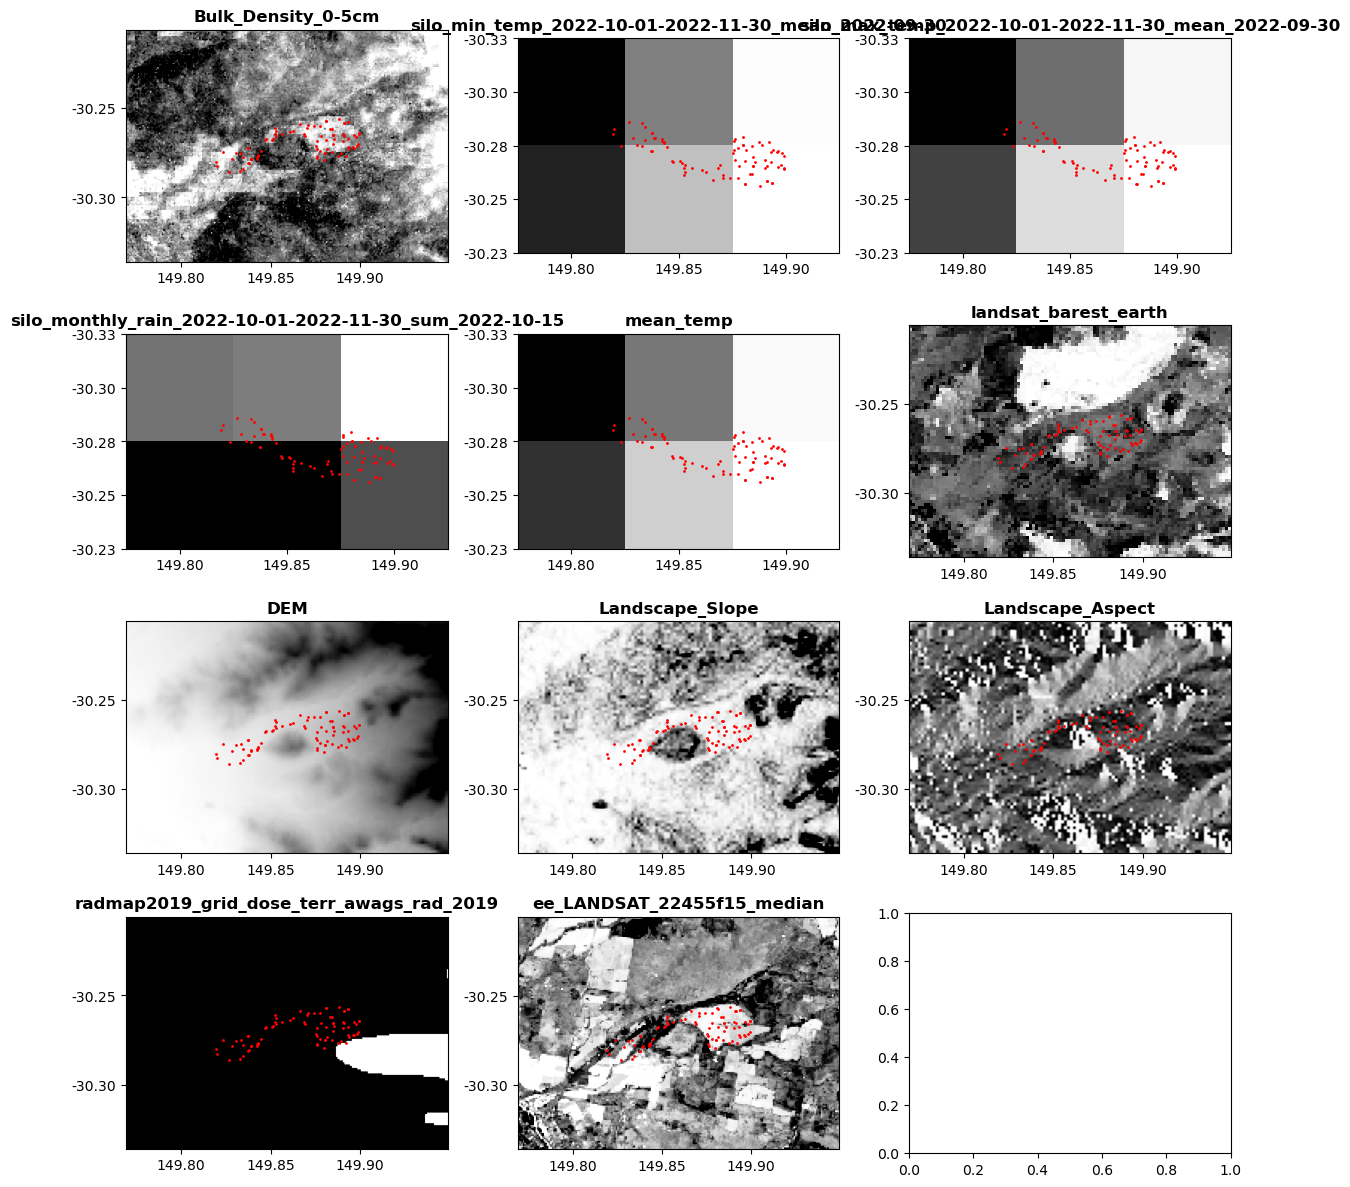

In [36]:
# Plot one of that datasets with the points on top
gh.utils.plot_rasters(rasters,lngs,lats,titles)

# Done!

Now you have seen how aggregate some download processes occur within the `harvest.run` function. You can explore the files that have been output in the browser and take them for further analysis in your favorite software.

There are several more light processing tools, options, and functionality available already for the power-users, which we are gradually exposing to the run function directly callable from the settings file.